<a href="https://colab.research.google.com/github/renatojmf/CM1-Software-Detection-Prediciton/blob/main/MiniProjeto3-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProjeto 3 - LSTM - Redes Neurais 


## Empregar LSTM para prever o preço do Bitcoin de dezembro de 2014 a maio de 2018

### **Grupo: Josenildo Vicente de Araújo (jva@cin.ufpe.br), Lucas Thierry Chaves Muniz (ltcm@cin.ufpe.br), Nicholas Henrique Justino Ferreira (nhjf@cin.ufpe.br), Renato Joaquim Miranda Ferreira (rjmf@cin.ufpe.br)**

O seguinte MiniProjeto tem como objetivo praticar os conceitos e teorias aprendidas na disciplina de Redes Neurais a respeito do funcionamento do modelo de LSTM para predição do preço do bitcoin numa determinada janela temporal. De maneira a variar os parâmetros do modelo treinado e observar seus resultados, a rede utilizada em questão, tem como função fazer a predição do preço da moeda aprendendo a partir do valores informados dataset disponibilizado passando diversos atributos da moeda no dia corrente, como o valor inicial que ela foi comercializada no dia em questão, qual o valor mais alto atingido no dia, o valor mais baixo do dia e em qual valor ela foi fechada bem como seu volume inicial e final. A partir dessas informações a rede tentará prever em qual valor o bitcoin será fechado para o dado instante de tempo.

Começamos pela importação do pacote das bibliotecas do tensorflow,pandas e numpu para construção do modelo, importação do dataset. O matplotlib será a biblioteca gráfica e será usada quando for pertinente

In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/brynmwangy/predicting-bitcoin-prices-using-LSTM/master/btc.csv',encoding='ISO-8859-1')
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


Nesse ponto selecionamos apenas a coluna do dataset relativa ao preço de fechamento da moeda para predição de seu valor

In [25]:
#selecting only the column that we are going to use in the prediction process
data_to_use=df['Close'].values
data_to_use = data_to_use[::-1]
data_to_use

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

Com o novo dataset em mãos, é feito o uso do StandardScaler para normalizar o dataset e seguir com as análises

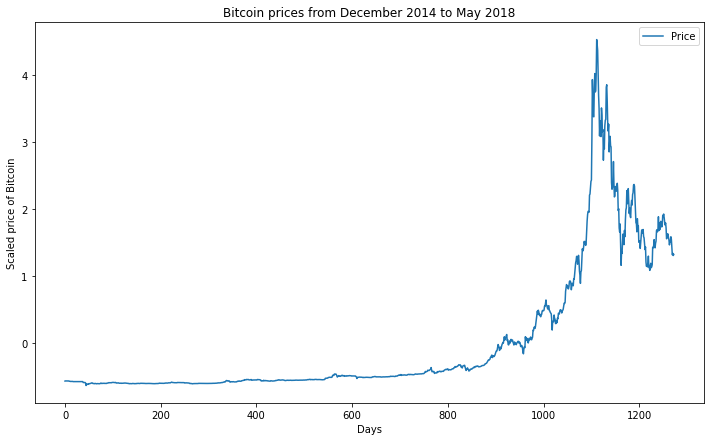

In [26]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

É separado o dataset na proporção de 80% para o conjunto de treinamento e 20% para o conjunto de testes bem como seleção das labels e features de acordo com o tamanho da janela escolhida, por exemplo, caso o window_size = 1 então tentará ser previsto o valor de hoje usando apenas a informação do dia anterior

In [82]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [28]:
# Add the import statements 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Nesse ponto será contruído o modelo do LSTM no qual passamos os parâmetros como o batch_size, hidden_layer, window_size, clip_margin,learning_rate e epochs para o treinamento e construção do modelo, primariamente o otimizador utilizado será o Adam fornecido pelo tensorflow

In [61]:
import tensorflow as tf
#function to compute the gate states
def LSTM_cell(input, output, state, weights_input_gate,weights_input_hidden,bias_input,bias_forget,bias_output,bias_memory_cell
              ,weights_memory_cell,weights_forget_gate,weights_forget_hidden,weights_output_gate,weights_output_hidden,weights_memory_cell_hidden):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output


def lstm(params):
  batch_size = params['batch_size']
  hidden_layer = params['hidden_layer']
  window_size = params['window_size']
  clip_margin = params['clip_margin']
  learning_rate = params['learning_rate']
  epochs = params['epochs']

  #we define the placeholders
  inputs = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1])
  targets = tf.compat.v1.placeholder(tf.float32, [batch_size, 1])



  #weights and implementation of LSTM cell
  # LSTM weights

  #Weights for the input gate
  weights_input_gate = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_input_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_input = tf.Variable(tf.zeros([hidden_layer]))

  #weights for the forgot gate
  weights_forget_gate = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_forget_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_forget = tf.Variable(tf.zeros([hidden_layer]))

  #weights for the output gate
  weights_output_gate = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_output_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_output = tf.Variable(tf.zeros([hidden_layer]))

  #weights for the memory cell
  weights_memory_cell = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
  weights_memory_cell_hidden = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
  bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

  #Output layer weigts
  weights_output = tf.Variable(tf.random.truncated_normal([hidden_layer, 1], stddev=0.05))
  bias_output_layer = tf.Variable(tf.zeros([1]))



  #we now define loop for the network
  outputs = []
  for i in range(batch_size): #Iterates through every window in the batch
    
      #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
      batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
      batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
      
      #for each point in the window we are feeding that into LSTM to get next output
      for ii in range(window_size):
          batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output,  weights_input_gate,weights_input_hidden,bias_input,bias_forget,bias_output,bias_memory_cell
              ,weights_memory_cell,weights_forget_gate,weights_forget_hidden,weights_output_gate,weights_output_hidden,weights_memory_cell_hidden)
          
      #last output is conisdered and used to get a prediction
      outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
  #we define the loss
  losses = []

  for i in range(len(outputs)):
      losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
      
  loss = tf.reduce_mean(losses)

  #we define optimizer with gradient clipping
  gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
  clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
  optimizer = tf.optimizers.Adam(learning_rate)
  trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.compat.v1.trainable_variables()))

  #we now train the network
  session = tf.compat.v1.Session()
  session.run(tf.compat.v1.global_variables_initializer())
  for i in range(epochs):
      traind_scores = []
      ii = 0
      epoch_loss = []
      while(ii + batch_size) <= len(X_train):
          X_batch = X_train[ii:ii+batch_size]
          y_batch = y_train[ii:ii+batch_size]
          
          o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
          
          epoch_loss.append(c)
          traind_scores.append(o)
          ii += batch_size
      if (i % 10) == 0:
        losss.append(np.mean(epoch_loss))
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

  for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

  i = 0
  while i+batch_size <= len(X_test): 
    
      o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
      i += batch_size
      tests.append(o)

  for i in range(len(tests)):
    for j in range(len(tests[i][0])):
      tests_new.append(tests[i][0][j])

  for i in range(1264):
    if i >= 1019:
      test_results.append(tests_new[i-1019])
    else:
      test_results.append(None)


Após construção do modelo, vamos finalmente aos testes, para esse teste escolhemos os valores 'padrões' do modelo para verificar o quão bem essa primeira versão de testes será

## Versão Original


In [83]:
from time import time
sup = []
tests = []
tests_new = []
test_results = []
losss = []
params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 7, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v1 = test_results

Epoch 0/200  Current loss: 0.021253297105431557
Epoch 10/200  Current loss: 0.015908461064100266
Epoch 20/200  Current loss: 0.008406588807702065
Epoch 30/200  Current loss: 0.014943369664251804
Epoch 40/200  Current loss: 0.007097167894244194
Epoch 50/200  Current loss: 0.000894384749699384
Epoch 60/200  Current loss: 0.0006656285258941352
Epoch 70/200  Current loss: 0.0004830528923776001
Epoch 80/200  Current loss: 0.0016634665662422776
Epoch 90/200  Current loss: 0.0007300815777853131
Epoch 100/200  Current loss: 0.0014838981442153454
Epoch 110/200  Current loss: 0.0005255926516838372
Epoch 120/200  Current loss: 0.0004893947043456137
Epoch 130/200  Current loss: 0.000576099322643131
Epoch 140/200  Current loss: 0.0005966920289210975
Epoch 150/200  Current loss: 0.0006633452139794827
Epoch 160/200  Current loss: 0.00036178473965264857
Epoch 170/200  Current loss: 0.000493532745167613
Epoch 180/200  Current loss: 0.0003274476621299982
Epoch 190/200  Current loss: 0.000285935209831222

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


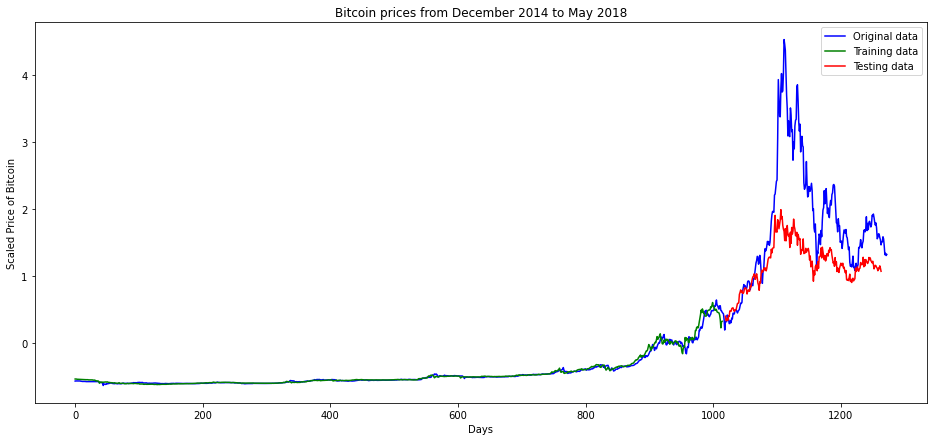

In [84]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

Como é possível observar, nosso modelo está bem próximo do valor de fechamento real do dataset real, conforme as épocas de treinamento vão passando chega tão próximo que é possível argumentar que são os mesmos valores.

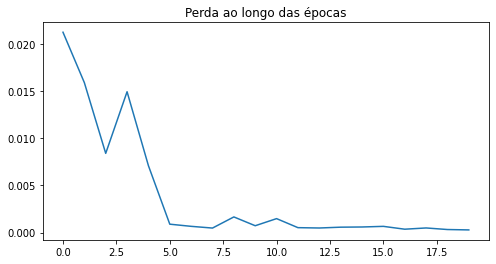

In [85]:
plt.figure(figsize=(8, 4))
plt.title('Perda ao longo das épocas')
plt.plot(losss)

## Versão 2.0

In [86]:
X, y = window_data(scaled_data, 3)


#we now split the data into training and test set
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

sup = []
tests = []
tests_new = []
test_results = []
losss = []

params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 3, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v2 = test_results

X_train size: (1018, 3, 1)
y_train size: (1018, 1)
X_test size: (252, 3, 1)
y_test size: (252, 1)
Epoch 0/200  Current loss: 0.026863694190979004
Epoch 10/200  Current loss: 0.003953571897000074
Epoch 20/200  Current loss: 0.005549504421651363
Epoch 30/200  Current loss: 0.0023044103290885687
Epoch 40/200  Current loss: 0.0025562946684658527
Epoch 50/200  Current loss: 0.0021234266459941864
Epoch 60/200  Current loss: 0.001797731383703649
Epoch 70/200  Current loss: 0.0015835611848160625
Epoch 80/200  Current loss: 0.0013575919438153505
Epoch 90/200  Current loss: 0.0011584865860641003
Epoch 100/200  Current loss: 0.0010208155727013946
Epoch 110/200  Current loss: 0.0014040571404621005
Epoch 120/200  Current loss: 0.0010569238802418113
Epoch 130/200  Current loss: 0.0009202578803524375
Epoch 140/200  Current loss: 0.0006704554543830454
Epoch 150/200  Current loss: 0.0007468059193342924
Epoch 160/200  Current loss: 0.0007880806806497276
Epoch 170/200  Current loss: 0.0006113935960456729

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


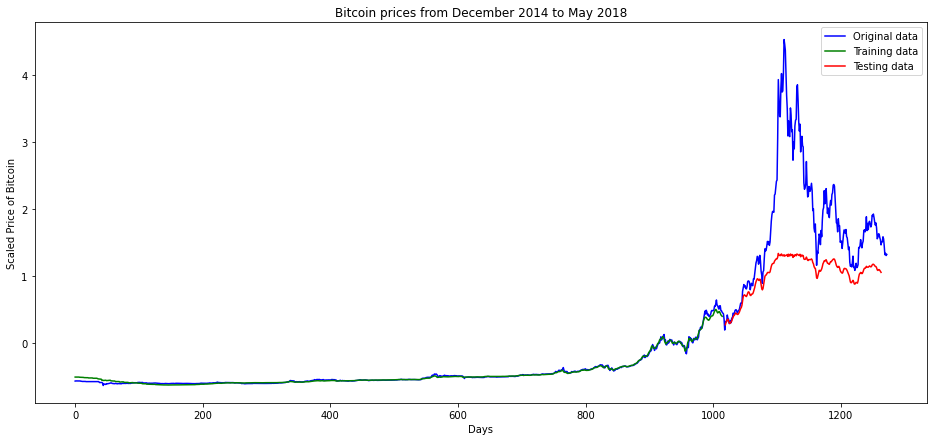

In [87]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

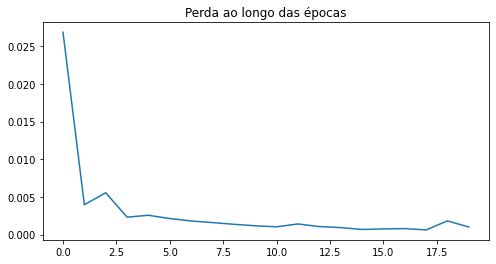

In [88]:
plt.figure(figsize=(8, 4))
plt.title('Perda ao longo das épocas')
plt.plot(losss)

## Versão 3.0

In [89]:
X, y = window_data(scaled_data, 10)


#we now split the data into training and test set
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

sup = []
tests = []
tests_new = []
test_results = []
losss = []

params = {'batch_size': 7, #how many windows of data we are passing at once
'window_size': 10, #how big window_size is (Or How many days do we consider to predict next point in the sequence)
'hidden_layer': 256, #How many units do we use in LSTM cell
'clip_margin': 4, #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
'learning_rate' : 0.001 ,
'epochs' : 200 }

t_now = time()
lstm(params)
duration = time() - t_now
print("duration time: %0.3fs" % duration)

results_v3 = test_results

X_train size: (1018, 10, 1)
y_train size: (1018, 1)
X_test size: (245, 10, 1)
y_test size: (245, 1)
Epoch 0/200  Current loss: 0.02243177406489849
Epoch 10/200  Current loss: 0.04219018295407295
Epoch 20/200  Current loss: 0.07212473452091217
Epoch 30/200  Current loss: 0.030948089435696602
Epoch 40/200  Current loss: 0.0041602603159844875
Epoch 50/200  Current loss: 0.0022277419921010733
Epoch 60/200  Current loss: 0.006637990940362215
Epoch 70/200  Current loss: 0.0015329660382121801
Epoch 80/200  Current loss: 0.0012344345450401306
Epoch 90/200  Current loss: 0.004178921692073345
Epoch 100/200  Current loss: 0.0012551210820674896
Epoch 110/200  Current loss: 0.0012634973973035812
Epoch 120/200  Current loss: 0.0010272642830386758
Epoch 130/200  Current loss: 0.0009570908732712269
Epoch 140/200  Current loss: 0.0008226251811720431
Epoch 150/200  Current loss: 0.0006396510289050639
Epoch 160/200  Current loss: 0.0006628721603192389
Epoch 170/200  Current loss: 0.0005512138595804572
Ep

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


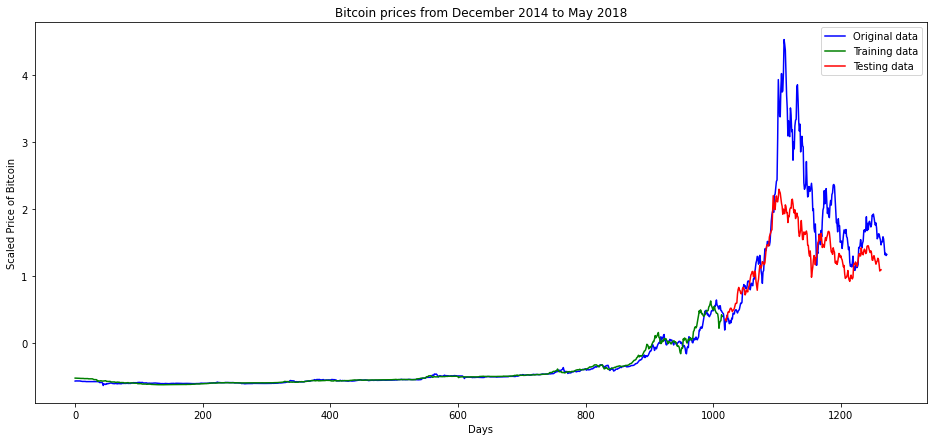

In [90]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='Training data',color='green')
plt.plot(test_results, label='Testing data',color='red')
plt.legend()
plt.show()

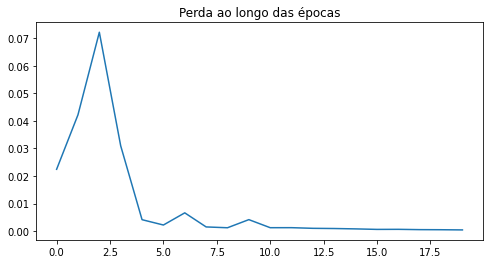

In [91]:
plt.figure(figsize=(8, 4))
plt.title('Perda ao longo das épocas')
plt.plot(losss)

## Comparando as versões

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


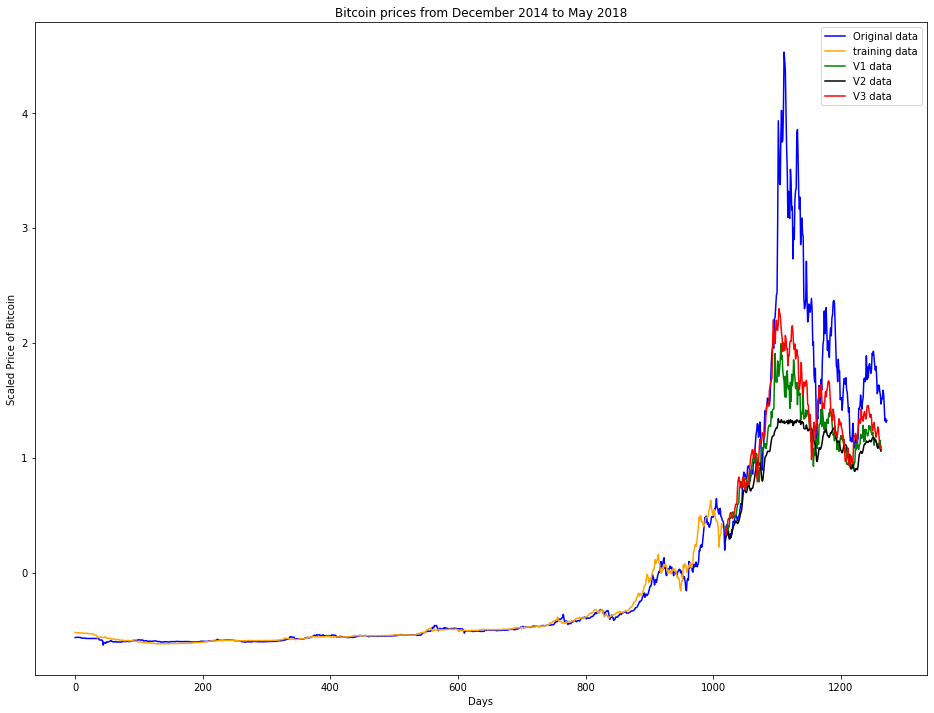

In [98]:
#we now plot predictions from the network
plt.figure(figsize=(16,12))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data',color='blue')
plt.plot(sup, label='training data',color='orange')
plt.plot(results_v1, label='V1 data',color='green')
plt.plot(results_v2, label='V2 data',color='black')
plt.plot(results_v3, label='V3 data',color='red')
plt.legend()
plt.show()